In [1]:
import pickle
from scipy import sparse
from sklearn.linear_model import Ridge, LogisticRegression
import statistics
from tqdm import tqdm
import scipy.stats as sts

In [2]:
from datetime import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import itertools
import math

## Подготовка данных

In [3]:
with open('results.pkl', 'rb') as file:
    results = pickle.load(file)
with open('players.pkl', 'rb') as file:
    players = pickle.load(file)
with open('tournaments.pkl', 'rb') as file:
    tournaments = pickle.load(file)

In [4]:
players = pd.DataFrame(players).transpose()
players["id"] = players["id"].astype(int)

tournaments_pd = pd.DataFrame(tournaments).transpose()
tournaments_pd["id"] = tournaments_pd["id"].astype(int)
tournaments_pd["dateStart"] = pd.to_datetime(tournaments_pd["dateStart"].str[:10], infer_datetime_format=True)
tournaments_pd["dateEnd"] = pd.to_datetime(tournaments_pd["dateEnd"].str[:10], infer_datetime_format=True)

tournaments_train = tournaments_pd[tournaments_pd["dateStart"].dt.year == 2019].reset_index(drop=True)
tournaments_test = tournaments_pd[tournaments_pd["dateStart"].dt.year == 2020].reset_index(drop=True)

/var/folders/3d/d1dc45z108zcqvtsjft6n_140000gp/T/ipykernel_2018/3564731581.py:6: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  tournaments_pd["dateStart"] = pd.to_datetime(tournaments_pd["dateStart"].str[:10], infer_datetime_format=True)
/var/folders/3d/d1dc45z108zcqvtsjft6n_140000gp/T/ipykernel_2018/3564731581.py:7: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  tournaments_pd["dateEnd"] = pd.to_datetime(tournaments_pd["dateEnd"].str[:10], infer_datetime_format=True)


In [5]:
tournaments_train.head()

,id,name,dateStart,dateEnd,type,season,orgcommittee,synchData,questionQty
0,4772,Синхрон северных стран. Зимний выпуск,2019-01-05,2019-01-09,"{'id': 3, 'name': 'Синхрон'}",/seasons/52,"[{'id': 28379, 'name': 'Константин', 'patronym...",{'dateRequestsAllowedTo': '2019-01-09T23:59:59...,"{'1': 12, '2': 12, '3': 12}"
1,4973,Балтийский Берег. 3 игра,2019-01-25,2019-01-29,"{'id': 3, 'name': 'Синхрон'}",/seasons/52,"[{'id': 23030, 'name': 'Марина', 'patronymic':...",{'dateRequestsAllowedTo': '2019-01-28T23:59:59...,"{'1': 12, '2': 12, '3': 12}"
2,4974,Балтийский Берег. 4 игра,2019-03-01,2019-03-05,"{'id': 3, 'name': 'Синхрон'}",/seasons/52,"[{'id': 23030, 'name': 'Марина', 'patronymic':...",{'dateRequestsAllowedTo': '2019-03-04T23:59:59...,"{'1': 12, '2': 12, '3': 12}"
3,4975,Балтийский Берег. 5 игра,2019-04-05,2019-04-09,"{'id': 3, 'name': 'Синхрон'}",/seasons/52,"[{'id': 23030, 'name': 'Марина', 'patronymic':...",{'dateRequestsAllowedTo': '2019-04-08T23:59:59...,"{'1': 12, '2': 12, '3': 12}"
4,4986,ОВСЧ. 6 этап,2019-02-15,2019-02-19,"{'id': 3, 'name': 'Синхрон'}",/seasons/52,"[{'id': 59140, 'name': 'Борис', 'patronymic': ...",{'dateRequestsAllowedTo': '2019-02-19T23:59:59...,"{'1': 12, '2': 12, '3': 12}"


In [6]:
results_have_mask = {}
for key, value in results.items():
    try:
        if value[0]["mask"] is not None:
            results_have_mask[key] = value
    except Exception:
        pass

results_filtered = {}
for tournament_id, teams in results_have_mask.items():
    dict_ = {}
    dict_["teams"] = [team["team"]["id"] for team in teams]
    dict_["results"] = [team["mask"] for team in teams]
    try:
        dict_["position"] = [team["position"] for team in teams]
    except Exception:
        dict_["position"] = [-1 for team in teams]
        print("No position")
    all_teams = []
    for team in teams:
        curr_team = []
        for member in team["teamMembers"]:
            curr_team.append(member["player"]["id"])
        all_teams.append(curr_team)
    dict_["team_members"] = all_teams
    results_filtered[tournament_id] = dict_

In [7]:
results_filtered_pd = pd.DataFrame(results_filtered).transpose()
results_filtered_pd["id"] = results_filtered_pd.index
results_filtered_pd.reset_index(drop=True, inplace=True)

tournaments_results_train = tournaments_train.merge(results_filtered_pd, on="id")
tournaments_results_test = tournaments_test.merge(results_filtered_pd, on="id")

In [8]:
tournaments_results_train.head()

,id,name,dateStart,dateEnd,type,season,orgcommittee,synchData,questionQty,teams,results,position,team_members
0,4772,Синхрон северных стран. Зимний выпуск,2019-01-05,2019-01-09,"{'id': 3, 'name': 'Синхрон'}",/seasons/52,"[{'id': 28379, 'name': 'Константин', 'patronym...",{'dateRequestsAllowedTo': '2019-01-09T23:59:59...,"{'1': 12, '2': 12, '3': 12}","[45556, 1030, 4252, 5444, 40931, 47075, 53185,...","[111111111011111110111111111100010010, 1111111...","[1, 5.5, 5.5, 5.5, 5.5, 5.5, 5.5, 5.5, 5.5, 12...","[[6212, 18332, 18036, 22799, 15456, 26089], [1..."
1,4973,Балтийский Берег. 3 игра,2019-01-25,2019-01-29,"{'id': 3, 'name': 'Синхрон'}",/seasons/52,"[{'id': 23030, 'name': 'Марина', 'patronymic':...",{'dateRequestsAllowedTo': '2019-01-28T23:59:59...,"{'1': 12, '2': 12, '3': 12}","[45556, 69309, 27522, 67979, 2055, 4032, 6936,...","[111111111111111011110101110111111111, 1111111...","[1.5, 1.5, 3.5, 3.5, 7.5, 7.5, 7.5, 7.5, 7.5, ...","[[6212, 18332, 18036, 22799, 7008, 26089], [27..."
2,4974,Балтийский Берег. 4 игра,2019-03-01,2019-03-05,"{'id': 3, 'name': 'Синхрон'}",/seasons/52,"[{'id': 23030, 'name': 'Марина', 'patronymic':...",{'dateRequestsAllowedTo': '2019-03-04T23:59:59...,"{'1': 12, '2': 12, '3': 12}","[2865, 69309, 6874, 27522, 56664, 1021, 4622, ...","[111111111111111111111111111101111111, 1111111...","[1.5, 1.5, 4, 4, 4, 7, 7, 7, 13, 13, 13, 13, 1...","[[19411, 24290, 32979, 5195, 33806, 9680], [27..."
3,4975,Балтийский Берег. 5 игра,2019-04-05,2019-04-09,"{'id': 3, 'name': 'Синхрон'}",/seasons/52,"[{'id': 23030, 'name': 'Марина', 'patronymic':...",{'dateRequestsAllowedTo': '2019-04-08T23:59:59...,"{'1': 12, '2': 12, '3': 12}","[4174, 45556, 70530, 7864, 7896, 27119, 33088,...","[110101011111111111110011111110111110, 1111010...","[2, 2, 2, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7...","[[13345, 29425, 52183, 34417, 30772, 93424], [..."
4,4986,ОВСЧ. 6 этап,2019-02-15,2019-02-19,"{'id': 3, 'name': 'Синхрон'}",/seasons/52,"[{'id': 59140, 'name': 'Борис', 'patronymic': ...",{'dateRequestsAllowedTo': '2019-02-19T23:59:59...,"{'1': 12, '2': 12, '3': 12}","[69309, 49758, 312, 27177, 928, 38722, 45174, ...","[11111111111111110111101X111111111111, 1111111...","[1, 2, 3.5, 3.5, 6.5, 6.5, 6.5, 6.5, 11, 11, 1...","[[27822, 28751, 30270, 33620, 2421], [6482, 13..."


## Бейзлайн - логистическая регрессия на one-hot векторе игрока и one-hot векторе вопроса.

In [9]:
def helper(id_, string):
    if string is None:
        return ['_'.join([str(id_), '0'])], [0]
    s_list = list(string)
    result = []
    for s in s_list:
        try:
            result.append(int(s))
        except:
            result.append(0)
    ids = ['_'.join([str(id_), str(i)]) for i in range(len(result))]
    return ids, result

def prepare_data(data):
    tournament = data.drop(columns=["name", "dateStart", "dateEnd", "type", "season", "orgcommittee", "synchData", "questionQty"]).explode(["teams", "results", "position", "team_members"]).explode("team_members")
    tournament[[f'{"id"}_q', "results"]] = tournament.apply(lambda row: helper(row["id"], row["results"]), axis=1,
                                                result_type='expand')
    tournament = tournament.explode([f'{"id"}_q', "results"])
    tournament.dropna(inplace=True)
    return tournament

In [10]:
data_train = prepare_data(tournaments_results_train)
data_test = prepare_data(tournaments_results_test)

In [11]:
data_train.head()

,id,teams,results,position,team_members,id_q
0,4772,45556,1,1,6212,4772_0
0,4772,45556,1,1,6212,4772_1
0,4772,45556,1,1,6212,4772_2
0,4772,45556,1,1,6212,4772_3
0,4772,45556,1,1,6212,4772_4


In [12]:
data_train = data_train.astype(dtype={"teams": np.uint32, "results": np.uint8, "id": np.uint32, "team_members": np.uint32, "position": np.float32})
data_test = data_test.astype(dtype={"teams": np.uint32, "results": np.uint8, "id": np.uint32, "team_members": np.uint32, "position": np.float32})

In [13]:
from sklearn.base import BaseEstimator
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegressionCV, RidgeCV, LassoCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.stats.mstats import spearmanr, kendalltau

y_train = data_train["results"].copy()
ohe = OneHotEncoder()
X_train = ohe.fit_transform(data_train[["team_members", "id_q"]])

Для удобства использования в EM-алгоритме, напишем логистическую регрессию на PyTorch.

In [14]:
import torch.nn as nn
import torch
import torch.nn.functional as F
from IPython.display import clear_output


class LogReg(nn.Module):
    def __init__(self, in_feat, out_feat=1):
        super().__init__()

        self.linear = nn.Linear(in_feat, 1)
    
    def forward(self, x):
        return F.sigmoid(self.linear(x))

In [15]:
X_train = X_train.tocoo()

x = torch.sparse.FloatTensor(
    torch.LongTensor(np.vstack((X_train.row, X_train.col))),
    torch.FloatTensor(X_train.data)
)

y = torch.FloatTensor(data_train["results"].values).view(-1, 1)

In [16]:
model = LogReg(x.shape[1])

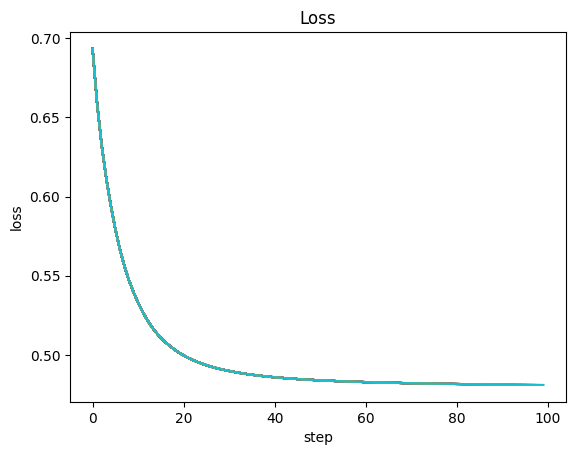

In [17]:
NUM_ITERS = 100

model = LogReg(x.shape[1])

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
losses = []

fig, ax = plt.subplots()

for i in range(NUM_ITERS):
    optimizer.zero_grad()
    preds = model(x)

    loss = criterion(preds, y)
    loss.backward()

    optimizer.step()

    losses.append(loss.detach().item())

    clear_output(wait=True)
    ax.plot(losses)
    ax.set_xlabel('step')
    ax.set_ylabel('loss')
    ax.set_title('Loss');
    display(fig)

clear_output(wait=True)

Найдем лучших игроков по мнению нашей модели.

In [18]:
player_skill = {}

linear_weights = model.linear.weight.data[0].numpy()
feature_names = ohe.get_feature_names_out()

for idx, player_id in enumerate(feature_names):
    if player_id.startswith('team_members'):
        player_skill[int(player_id[13:])] = linear_weights[idx]
        
top = sorted(
    [(player_id, power) for player_id, power in player_skill.items()],
    reverse=True, key=lambda x: x[1]
            )[:30]

dict_top = defaultdict(list)

for place, (player_id, power) in enumerate(top, 1):
    dict_top['id'].append(player_id)
    dict_top['skill'].append(power)
    dict_top['place'].append(place)
    dict_top["name"].append(players.loc[player_id]["name"])
    dict_top["surname"].append(players.loc[player_id]["surname"])
dict_top = pd.DataFrame(dict_top)

In [19]:
dict_top

,id,skill,place,name,surname
0,36844,4.077776,1,Павел,Щербина
1,27403,3.391380,2,Максим,Руссо
2,4270,3.267650,3,Александра,Брутер
3,28751,3.239450,4,Иван,Семушин
4,40411,3.150899,5,Дмитрий,Кудинов
5,38175,3.083891,6,Максим,Пилипенко
6,30152,3.078051,7,Артём,Сорожкин
7,30270,3.074029,8,Сергей,Спешков
8,27822,3.072727,9,Михаил,Савченков
9,202410,2.973523,10,Валентина,Подюкова


In [20]:
torch.save(model.state_dict(), "./lm.pth")

## TODO: Сравнить с реальным рейтингом
Не получилось найти способ, чтобы получить топ-игроков :(

## Рейтинг система

Предложенное решение:

Пусть сила команды - вероятность ответить на средний вопрос турнира хотя бы одному из участников команды, т.е:

$$ Skill_{team} = 1 - \prod_{i=1}^N(1 - sigmoid(P_{i} + Q_{diffmean} + b)$$, где $P_{i}$ - скилл игрока $i$, $N$ - количество игроков в команде,  $Q_{diffmean}$ - средняя сложность вопроса на турнире, а $b$ - bias.

In [22]:
model.load_state_dict(torch.load("./lm.pth"))

<All keys matched successfully>

In [23]:
class TeamRanking:

    def __init__(self, model, ohe):
        self.player_skill = {}
        self.tourn_q_diff = defaultdict(list)

        linear_weights = model.linear.weight.data[0].numpy()
        feature_names = ohe.get_feature_names_out()

        for idx, player_id in enumerate(feature_names):
            if player_id.startswith('team_members'):
                self.player_skill[int(player_id[13:])] = linear_weights[idx]
            else:
                self.tourn_q_diff[player_id.split("_")[2]].append(linear_weights[idx])
        
        self.tourn_q_mean = {t_id: np.mean(q) for t_id, q in self.tourn_q_diff.items()}
        self.na_q = sum(self.tourn_q_mean.values()) / len(self.tourn_q_mean)
        self.na_player = sum(self.player_skill.values()) / len(self.player_skill)
        self.bias = model.linear.bias.data[0].numpy()
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def predict(self, data):
        data = data.copy()
        data["player_skill"] = data["team_members"].map(self.player_skill)
        data["player_skill"].fillna(self.na_player, inplace=True)
        
        data["tourn_q_mean"] = data["id"].map(self.tourn_q_mean)
        data["tourn_q_mean"].fillna(self.na_q, inplace=True)
        
        data["prob2answer"] = data.apply(lambda row: self.sigmoid(row["player_skill"] + row["tourn_q_mean"] + self.bias), axis=1)
        
        ratings = data.groupby(["id", "teams"])["prob2answer"].apply(lambda x: np.prod(1 - x))
        real_position = data.groupby(["id", "teams"])["position"].first()
        
        result = pd.concat([ratings, real_position], axis=1)
        result.sort_values(["id", "prob2answer"], ascending=[True, True], inplace=True)
        
        return result

    def eval(self, result):
        def safe_spearman(x, y):
            try:
                return spearmanr(x, y).correlation
            except:
                return 1

        spearman = result.groupby("id").apply(lambda x: safe_spearman(x["position"], x["prob2answer"])).mean()
        kendall = result.groupby("id").apply(lambda x: kendalltau(x["position"], x["prob2answer"]).correlation).mean()
        
        return spearman, kendall


        

In [24]:
import gc
torch.cuda.empty_cache()
gc.collect()

10

In [25]:
ranking_model = TeamRanking(model, ohe)

In [26]:
res = ranking_model.predict(data_test)

In [27]:
spearman, kendall = ranking_model.eval(res)

In [28]:
print(f'Spearman rho test: {spearman}')
print(f'Kendall rho test: {kendall}')

Spearman rho test: 0.7899785631893803
Kendall rho test: 0.6299620826434364


## EM - схема

Будем считать что:

При ответе одного игрока команды на вопрос на вопрос автоматически отвечают все игроки команды: $p(team_i = 1|player_j = 1) = 1$, если команда неправильно ответила на вопрос, то ни один игрок этой команды не ответил на этот вопрос: $p(player_j = 1 | 
team_i = 0) = 0$, выполняется условие независимости ответов игроков на вопросы

Теперь мы будем предсказывать не $p(player_j = 1) = 1$, а $p(player_{j} = 1 | team_i = 1)$, где $j \in team_i$ 

По теореме Байеса:

<center>$p(player_{j} = 1 | team_i = 1) = \frac{p(team_{i} = 1 | player_j = 1)p(player_j = 1)}{p(team_i = 1)}$</center>

Тогда используя наши предположения, можем найти обновление вероятностей, которое представляет собой Expectation шаг:

<center>$p(player_{j} = 1 | team_i = 1) = \frac{sigmoid(P_{i} + Q_{diffmean} + b)}{\prod_{i=1}^N(1 - sigmoid(P_{i} + Q_{diffmean} + b))}$</center>

In [29]:
def expectation_step(data, new_predictions):
    data["y_pred"] = new_predictions
    data.loc[data["results"] == 0, "y_pred"] = 0
    denom = data.loc[data["results"] == 1].groupby(["teams", "id_q"])["y_pred"].transform(lambda x: 1 - np.prod(1 - x.values))
    data.loc[data["results"] == 1, "y_pred"] = data.loc[data["results"] == 1, "y_pred"] / denom
    return data

In [25]:
data = data_train.copy()

In [23]:
%matplotlib inline

Epoch: 10
Spearman: 0.8059419436747862
Kendall: 0.6498619528612088


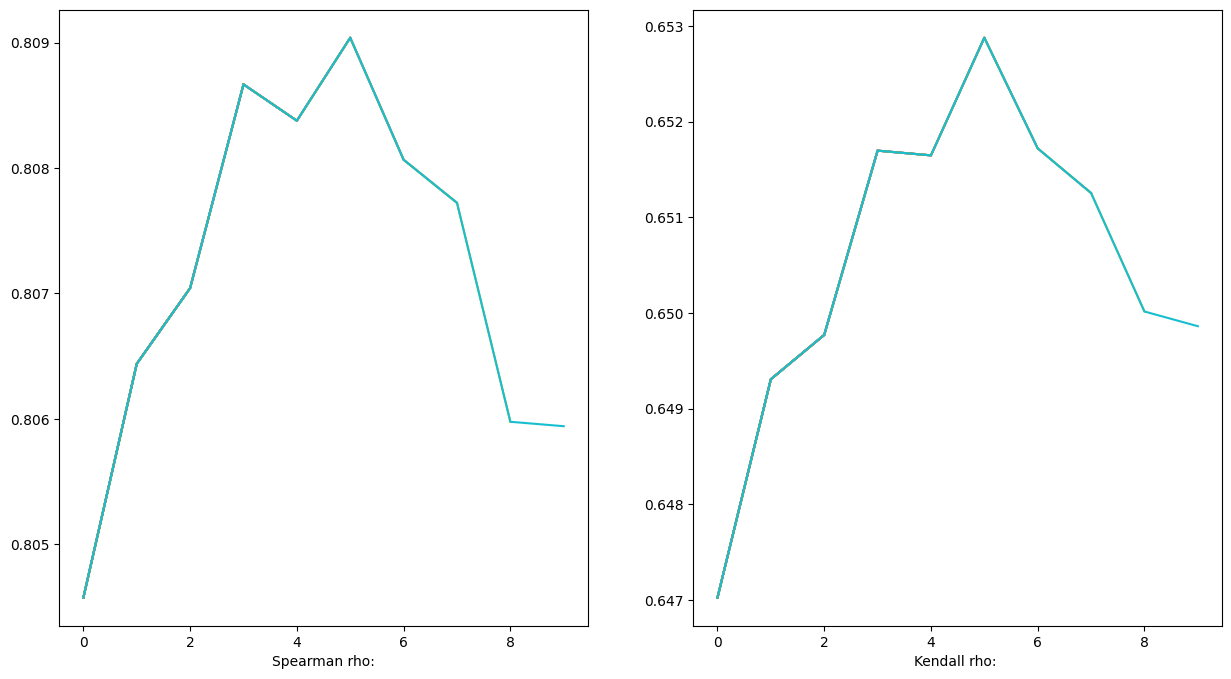

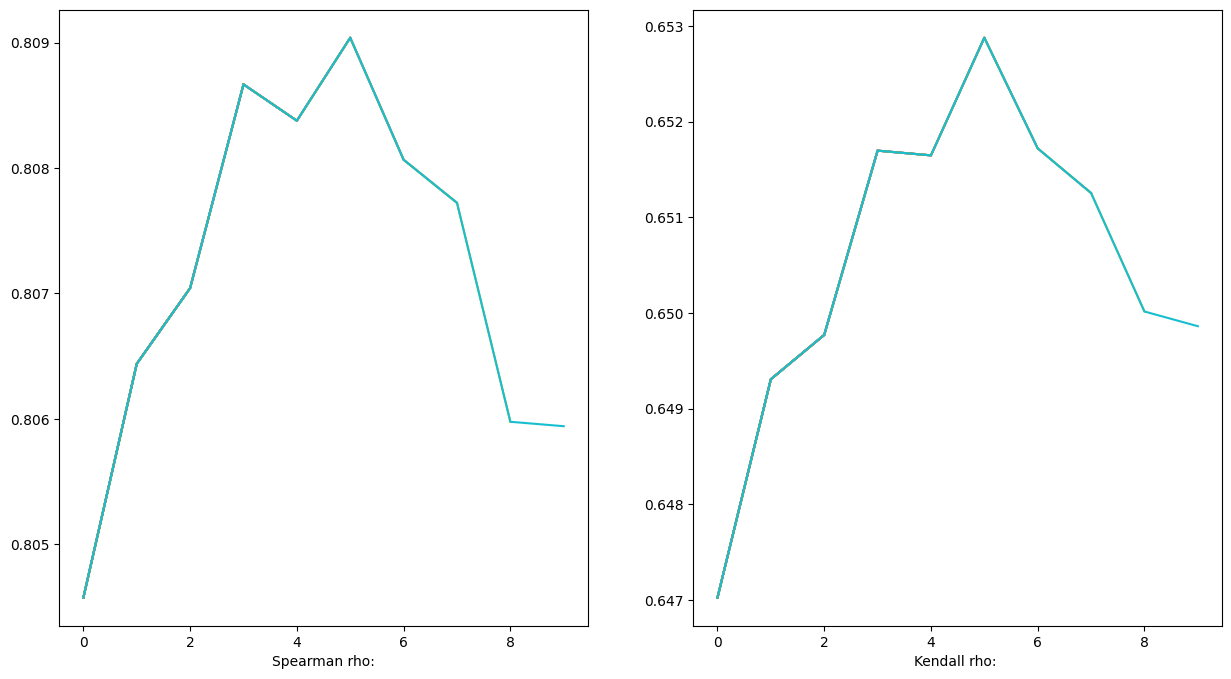

In [26]:
NUM_ITERS = 10

losses = []
spearmans = []
kendalls = []

model.eval()
predictions = model(x).detach().numpy().ravel()
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

for i in range(NUM_ITERS):
    model.train()
    print("Entering function")
    data = expectation_step(data, predictions)
    y = torch.FloatTensor(data['y_pred'].values).view(-1, 1)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    n_iter = 100

    for j in tqdm(range(n_iter)):
        optimizer.zero_grad()
        preds = model(x)

        loss = criterion(preds, y)
        loss.backward()

        optimizer.step()
        
    model.eval()
    predictions = model(x).detach().numpy().ravel()

    ranking_model = TeamRanking(model, ohe)
    res = ranking_model.predict(data_test)
    spearman, kendall = ranking_model.eval(res)

    spearmans.append(spearman)
    kendalls.append(kendall)
    
    clear_output(wait=True)
    print(f"Epoch: {i + 1}")
    print(f"Spearman: {spearman}")
    print(f"Kendall: {kendall}")
    
    ax[0].plot(spearmans)
    ax[0].set_xlabel("Spearman rho:")
    ax[1].plot(kendalls)
    ax[1].set_xlabel("Kendall rho: ")
    display(fig)

In [27]:
torch.save(model.state_dict(), "./final_em_model.pt")

Видим, что EM-схема тут помогла, но немного странно, что потом метрики начали падать

## Рейтинг-лист

Попробуем оценить сложность турниров через среднюю сложность вопросов на нем

In [34]:
parameters = model.linear.weight.data[0].numpy()
tourn_q_mean = defaultdict(list)

for i, name in enumerate(ohe.get_feature_names_out()):
    if name.startswith('id_q'):
        tourn_q_mean[int(name.split('_')[2])].append(parameters[i])
tourn_q_mean = {t_id: np.mean(q) for t_id, q in tourn_q_mean.items()}

In [35]:
top_tourns = tournaments_train[["id", "name"]].copy()
top_tourns['rating'] = top_tourns["id"].map(tourn_q_mean)

In [36]:
top_tourns.sort_values('rating', inplace=True)

Самые сложные турниры:

In [37]:
top_tourns[:15]

,id,name,rating
674,6149,Чемпионат Санкт-Петербурга. Первая лига,-4.525503
549,5928,Угрюмый Ёрш,-2.562106
375,5684,Синхрон высшей лиги Москвы,-2.382765
650,6101,Воображаемый музей,-2.288672
43,5159,Первенство правого полушария,-2.216910
551,5930,Зеркало мемориала памяти Михаила Басса,-2.089704
288,5587,Записки охотника,-2.063494
383,5693,Знание – Сила VI,-1.990962
26,5083,Ускользающая сова,-1.942768
226,5515,Чемпионат Минска. Лига А. Тур четвёртый,-1.888392


Есть чемпионаты Мира, России, Москвы, Санкт-Петербурга, Минска, выглядит как будто достаточно хорошо нашли сложные турниры

In [42]:
top_tourns[-28:-13]

,id,name,rating
597,5990,Открытый кубок УМЭД,1.685030
72,5313,(а)Синхрон-lite. Лига старта. Эпизод VI,1.698616
392,5704,(а)Синхрон-lite. Лига старта. Эпизод X,1.713771
371,5679,Чемпионат Караганды,1.723744
275,5570,Турнир малых факультетов МГУ,1.738028
607,6003,Второй тематический турнир имени Джоуи Триббиани,1.744591
10,5012,Школьный Синхрон-lite. Выпуск 2.5,1.802438
9,5011,(а)Синхрон-lite. Лига старта. Эпизод IV,1.856552
300,5601,Межфакультетский кубок МГУ. Отбор №4,1.902398
390,5702,(а)Синхрон-lite. Лига старта. Эпизод IX,2.011011


Достаточно много Синхрон-lite, школьных/студенческих турниров, как будто легкие турниры тоже хорошо нашли)